In [45]:
# 0) Imports & folders
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3

BASE = Path(".")  # your notebook folder
OUTPUTS = BASE / "outputs"
DBDIR = BASE / "database"

OUTPUTS.mkdir(exist_ok=True)
DBDIR.mkdir(exist_ok=True)

print("Outputs dir:", OUTPUTS.resolve())
print("Database dir:", DBDIR.resolve())



Outputs dir: C:\Users\Admin\Data Analysis Assignment\outputs
Database dir: C:\Users\Admin\Data Analysis Assignment\database


In [ ]:
import pandas as pd

# Load raw datasets (your filenames)
maternal_raw = pd.read_csv("WB_WDI_SH_STA_MMRT.csv")
labor_raw = pd.read_csv("WB_WDI_SL_TLF_CACT_FE_ZS.csv")


# Inspect structure
print("Maternal raw shape:", maternal_raw.shape)
print("Labor raw shape:", labor_raw.shape)

# Peek at structure
print("\nMaternal columns:", list(maternal_raw.columns))
print("Labor columns:", list(labor_raw.columns))

maternal_raw.head()

In [35]:
# Q1.2) Clean: Maternal Mortality (South Africa only)
# We filter by country & indicator, keep Year + Value, rename, convert to numeric, drop NA, sort
maternal_sa = maternal_raw[
    (maternal_raw["REF_AREA_NAME"] == "South Africa") &
    (maternal_raw["INDICATOR_ID"] == "WB_WDI_SH_STA_MMRT")
][["TIME_PERIOD", "OBS_VALUE"]].copy()

maternal_sa = maternal_sa.rename(columns={
    "TIME_PERIOD": "Year",
    "OBS_VALUE": "Maternal_Mortality_per_100k"
})

maternal_sa["Year"] = pd.to_numeric(maternal_sa["Year"], errors="coerce")
maternal_sa["Maternal_Mortality_per_100k"] = pd.to_numeric(maternal_sa["Maternal_Mortality_per_100k"], errors="coerce")
maternal_sa = maternal_sa.dropna().sort_values("Year").reset_index(drop=True)

print("Maternal (ZAF) rows:", len(maternal_sa))
maternal_sa.head()




Maternal (ZAF) rows: 21


Year  Maternal_Mortality_per_100k
0  2000                        173.0
1  2001                        168.0
2  2002                        193.0
3  2003                        205.0
4  2004                        232.0

In [37]:
# Q1.3) Clean: Female Labor Force (% of ages 15+, South Africa only)
labor_sa = labor_raw[
    (labor_raw["REF_AREA_NAME"] == "South Africa") &
    (labor_raw["INDICATOR_ID"] == "WB_WDI_SL_TLF_CACT_FE_ZS")
][["TIME_PERIOD", "OBS_VALUE"]].copy()

labor_sa = labor_sa.rename(columns={
    "TIME_PERIOD": "Year",
    "OBS_VALUE": "Female_Labor_Force_%"
})

labor_sa["Year"] = pd.to_numeric(labor_sa["Year"], errors="coerce")
labor_sa["Female_Labor_Force_%"] = pd.to_numeric(labor_sa["Female_Labor_Force_%"], errors="coerce")
labor_sa = labor_sa.dropna().sort_values("Year").reset_index(drop=True)

print("Labor (ZAF) rows:", len(labor_sa))
labor_sa.head()


Labor (ZAF) rows: 34


Year  Female_Labor_Force_%
0  1990                50.189
1  1991                50.234
2  1992                50.324
3  1993                50.259
4  1994                50.368

In [49]:
# Q1.4) Descriptive stats (each series)

print("Maternal stats:\n", maternal_sa[["Maternal_Mortality_per_100k"]].describe().T)
print("\nLabor stats:\n", labor_sa[["Female_Labor_Force_%"]].describe().T)

# Coverage years
print("\nMaternal years:", int(maternal_sa["Year"].min()), "to", int(maternal_sa["Year"].max()))
print("Labor years:", int(labor_sa["Year"].min()), "to", int(labor_sa["Year"].max()))


Maternal stats:
                              count        mean        std    min    25%  \
Maternal_Mortality_per_100k   21.0  176.142857  39.471871  118.0  141.0   

                               50%    75%    max  
Maternal_Mortality_per_100k  173.0  216.0  232.0  

Labor stats:
                       count       mean       std     min       25%     50%  \
Female_Labor_Force_%   34.0  51.009853  1.301102  47.036  50.24025  51.199   

                           75%     max  
Female_Labor_Force_%  52.02125  52.929  

Maternal years: 2000 to 2020
Labor years: 1990 to 2023


Year  Maternal_Mortality_per_100k  Female_Labor_Force_%
0  2000                        173.0                51.692
1  2001                        168.0                51.848
2  2002                        193.0                52.004
3  2003                        205.0                52.154
4  2004                        232.0                52.287

In [53]:
# Q1.5) Save cleaned CSVs (for your repo / reuse)
maternal_clean_path = OUTPUTS / "maternal_mortality_ZAF_clean.csv"
labor_clean_path = OUTPUTS / "female_labor_force_ZAF_clean.csv"

maternal_sa.to_csv(maternal_clean_path, index=False)
labor_sa.to_csv(labor_clean_path, index=False)

print("Saved:", maternal_clean_path.resolve())
print("Saved:", labor_clean_path.resolve())


Saved: C:\Users\Admin\Data Analysis Assignment\outputs\maternal_mortality_ZAF_clean.csv
Saved: C:\Users\Admin\Data Analysis Assignment\outputs\female_labor_force_ZAF_clean.csv


In [55]:
# Q2.1) Merge on Year (inner join so both series line up)
df = pd.merge(maternal_sa, labor_sa, on="Year", how="inner").sort_values("Year").reset_index(drop=True)
print("Merged shape:", df.shape)
df.head()


Merged shape: (21, 3)


Year  Maternal_Mortality_per_100k  Female_Labor_Force_%
0  2000                        173.0                51.692
1  2001                        168.0                51.848
2  2002                        193.0                52.004
3  2003                        205.0                52.154
4  2004                        232.0                52.287

In [57]:
# Q2.2) Convert to NumPy arrays
mort = df["Maternal_Mortality_per_100k"].to_numpy()
lab  = df["Female_Labor_Force_%"].to_numpy()

# Basic stats
summary = {
    "avg_maternal": np.mean(mort),
    "median_maternal": np.median(mort),
    "min_maternal": np.min(mort),
    "max_maternal": np.max(mort),
    "std_maternal": np.std(mort, ddof=1),
    "avg_labor": np.mean(lab),
    "median_labor": np.median(lab),
    "min_labor": np.min(lab),
    "max_labor": np.max(lab),
    "std_labor": np.std(lab, ddof=1),
}
summary


{'avg_maternal': 176.14285714285714,
 'median_maternal': 173.0,
 'min_maternal': 118.0,
 'max_maternal': 232.0,
 'std_maternal': 39.471870635030356,
 'avg_labor': 51.11923809523809,
 'median_labor': 51.692,
 'min_labor': 47.036,
 'max_labor': 52.624,
 'std_labor': 1.5269156789018152}

In [59]:
# Q2.3) Year-over-year % changes (first differences relative to prior year)
df["Mortality_YoY_%"] = df["Maternal_Mortality_per_100k"].pct_change() * 100
df["Labor_YoY_%"] = df["Female_Labor_Force_%"].pct_change() * 100

# Replace infinite values (if any) with NaN, then display head
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.head(10)


Year  Maternal_Mortality_per_100k  Female_Labor_Force_%  Mortality_YoY_%  \
0  2000                        173.0                51.692              NaN   
1  2001                        168.0                51.848        -2.890173   
2  2002                        193.0                52.004        14.880952   
3  2003                        205.0                52.154         6.217617   
4  2004                        232.0                52.287        13.170732   
5  2005                        221.0                52.394        -4.741379   
6  2006                        208.0                52.483        -5.882353   
7  2007                        218.0                52.562         4.807692   
8  2008                        216.0                52.624        -0.917431   
9  2009                        225.0                51.283         4.166667   

   Labor_YoY_%  
0          NaN  
1     0.301788  
2     0.300879  
3     0.288439  
4     0.255014  
5     0.204640  
6     0.169867  
7     0.150525  
8     0.117956  
9    -2.548267

In [61]:
# Q2.4) Correlation (Pearson)
corr = np.corrcoef(mort, lab)[0, 1]
print("Pearson correlation (Maternal Mortality vs Female Labor Force):", corr)


Pearson correlation (Maternal Mortality vs Female Labor Force): 0.19604980119131732


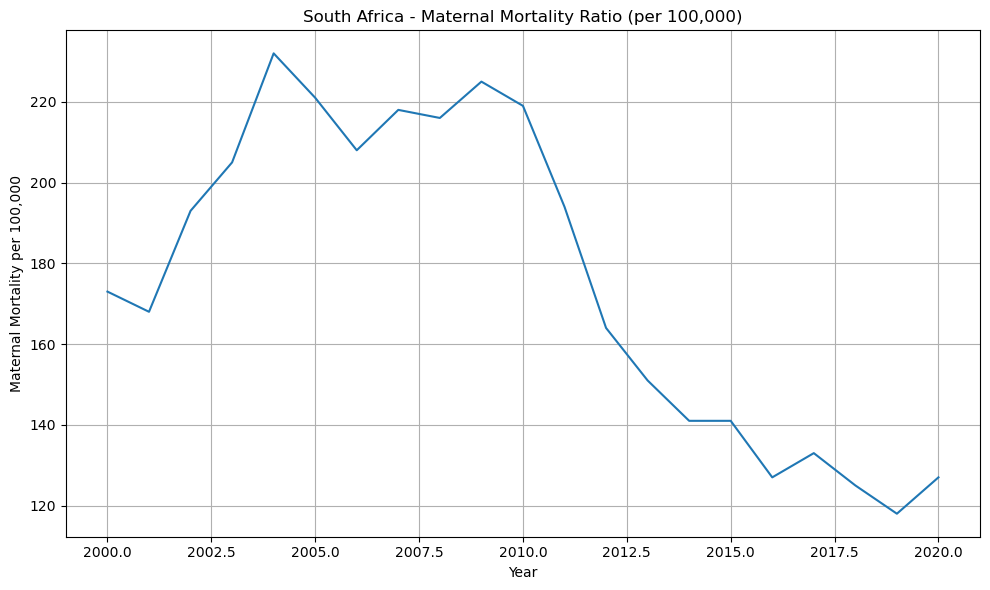

Saved figure: C:\Users\Admin\Data Analysis Assignment\outputs\trend_maternal_mortality.png


In [63]:
# Q3.1) Line: Maternal Mortality trend
plt.figure(figsize=(10, 6))
plt.plot(maternal_sa["Year"], maternal_sa["Maternal_Mortality_per_100k"])
plt.title("South Africa - Maternal Mortality Ratio (per 100,000)")
plt.xlabel("Year")
plt.ylabel("Maternal Mortality per 100,000")
plt.grid(True)
plt.tight_layout()
fig1 = OUTPUTS / "trend_maternal_mortality.png"
plt.savefig(fig1)
plt.show()
print("Saved figure:", fig1.resolve())


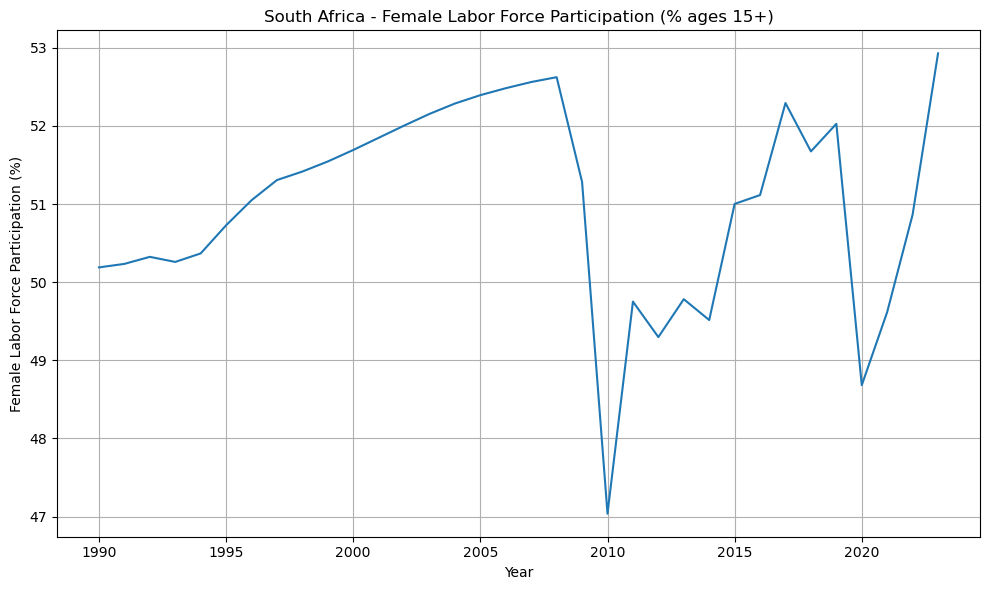

Saved figure: C:\Users\Admin\Data Analysis Assignment\outputs\trend_female_labor.png


In [65]:
# Q3.2) Line: Female Labor Force trend
plt.figure(figsize=(10, 6))
plt.plot(labor_sa["Year"], labor_sa["Female_Labor_Force_%"])
plt.title("South Africa - Female Labor Force Participation (% ages 15+)")
plt.xlabel("Year")
plt.ylabel("Female Labor Force Participation (%)")
plt.grid(True)
plt.tight_layout()
fig2 = OUTPUTS / "trend_female_labor.png"
plt.savefig(fig2)
plt.show()
print("Saved figure:", fig2.resolve())


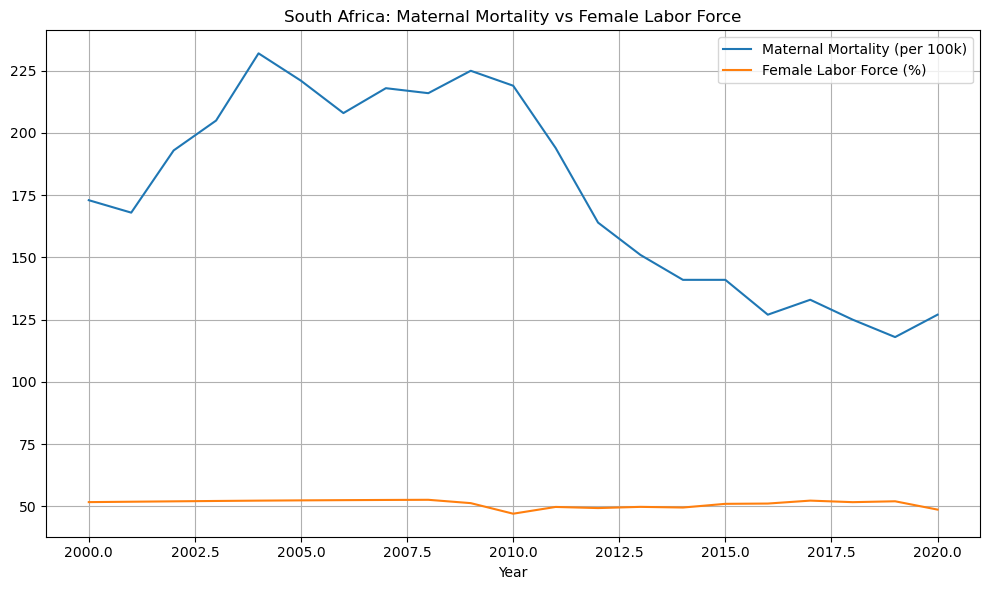

Saved figure: C:\Users\Admin\Data Analysis Assignment\outputs\combined_trends.png


In [67]:
# Q3.3) Combined line chart (both series)
plt.figure(figsize=(10, 6))
plt.plot(df["Year"], df["Maternal_Mortality_per_100k"], label="Maternal Mortality (per 100k)")
plt.plot(df["Year"], df["Female_Labor_Force_%"], label="Female Labor Force (%)")
plt.title("South Africa: Maternal Mortality vs Female Labor Force")
plt.xlabel("Year")
plt.grid(True)
plt.legend()
plt.tight_layout()
fig3 = OUTPUTS / "combined_trends.png"
plt.savefig(fig3)
plt.show()
print("Saved figure:", fig3.resolve())


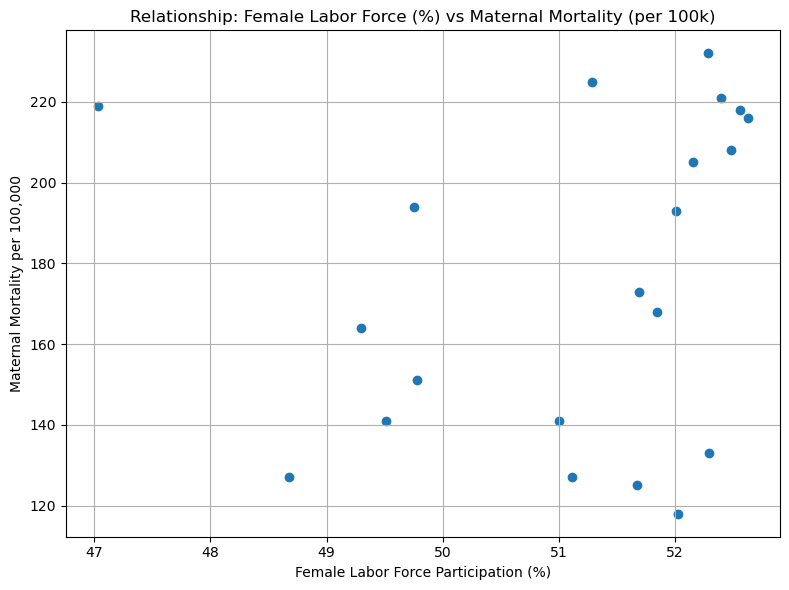

Saved figure: C:\Users\Admin\Data Analysis Assignment\outputs\scatter_relationship.png


In [69]:
# Q3.4) Scatter: Relationship (Labor % vs Maternal Mortality)
plt.figure(figsize=(8, 6))
plt.scatter(df["Female_Labor_Force_%"], df["Maternal_Mortality_per_100k"])
plt.title("Relationship: Female Labor Force (%) vs Maternal Mortality (per 100k)")
plt.xlabel("Female Labor Force Participation (%)")
plt.ylabel("Maternal Mortality per 100,000")
plt.grid(True)
plt.tight_layout()
fig4 = OUTPUTS / "scatter_relationship.png"
plt.savefig(fig4)
plt.show()
print("Saved figure:", fig4.resolve())


In [71]:
# Q4.1) Create SQLite DB & table, insert data
db_path = DBDIR / "south_africa_data.db"
conn = sqlite3.connect(db_path)
cur = conn.cursor()

cur.execute("DROP TABLE IF EXISTS combined")
cur.execute("""
CREATE TABLE combined (
    year INTEGER PRIMARY KEY,
    maternal REAL,
    labor REAL
)
""")

cur.executemany(
    "INSERT INTO combined (year, maternal, labor) VALUES (?,?,?)",
    df[["Year","Maternal_Mortality_per_100k","Female_Labor_Force_%"]].itertuples(index=False, name=None)
)
conn.commit()
print("Inserted", len(df), "rows into", db_path.resolve())


Inserted 21 rows into C:\Users\Admin\Data Analysis Assignment\database\south_africa_data.db


In [73]:
# Q4.2) Example SELECT (read back into pandas)
q = "SELECT * FROM combined WHERE year >= 2000 ORDER BY year"
df2000 = pd.read_sql(q, conn)
df2000.head()


year  maternal   labor
0  2000     173.0  51.692
1  2001     168.0  51.848
2  2002     193.0  52.004
3  2003     205.0  52.154
4  2004     232.0  52.287

In [75]:
# Q4.3) UPDATE & DELETE with safety (demonstration)
# Safe UPDATE (no change, just demo)
cur.execute("UPDATE combined SET labor = labor + 0 WHERE year = 2000")
conn.commit()

# Demonstrate guarded DELETE with rollback
conn.execute("BEGIN")
cur.execute("DELETE FROM combined WHERE year < 1900")  # This should affect 0 rows for modern data
conn.rollback()

# Verify row count intact
count = pd.read_sql("SELECT COUNT(*) AS n FROM combined", conn)
count


n
0  21

In [77]:
# Q4.4) Close connection after use
conn.close()
print("Closed DB connection.")


Closed DB connection.


In [81]:
# Q5) Export merged data and summary stats to Excel
from openpyxl import Workbook

with pd.ExcelWriter(OUTPUTS / "summary.xlsx", engine="openpyxl") as writer:
    # Raw merged data
    df.to_excel(writer, index=False, sheet_name="Data")
    
    # Stats (only numeric columns)
    df.select_dtypes(include=[np.number]).describe().T.to_excel(writer, sheet_name="Stats")
    
    # Summary metrics from NumPy
    pd.DataFrame([summary]).to_excel(writer, index=False, sheet_name="Summary_Metrics")
    
    # Percent changes
    df[["Year","Mortality_YoY_%","Labor_YoY_%"]].to_excel(writer, index=False, sheet_name="Percent_Changes")

print("Excel saved to:", (OUTPUTS / "summary.xlsx").resolve())



Excel saved to: C:\Users\Admin\Data Analysis Assignment\outputs\summary.xlsx
